# Predicting the price of Bulldozers using Machine Learning
In this notebook, we're going to go through an example machine learning project with the goal of predicting the sales price of bulldozers.

## 1. Problem Definition
> How well can we predict the future sales price of a bulldozer, given it's characterisitics and previous examples of how much similar bulldozers have been sold for?


## 2. Data
> The data is downloaded from the Kaggle Bluebook for Bulldozers competition : https://www.kaggle.com/competitions/bluebook-for-bulldozers/data

There are mainly 3 datasets in this project:
* **Train.csv** is the training set, which contains data through the end of 2011.
* **Valid.csv** is the validation set, which contains data from January 1, 2012 - April 30, 2012
* **Test.csv** is the test set which contains data from May 1, 2012 - November 2012.

## 3. Evaluation
The evaluation metric for this competition is Root Mean Squared Log Error (RMSLE) between the predicted prices and the actual prices.

**Note:** The goal for most regression metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimizes RMSLE.

## 4. Features
**Data Dictionary:** <br>
https://docs.google.com/spreadsheets/d/1gIp3CtwhCqIGkQBw20TZwZ13HqYBRcRk8ClBaAIGsQs/edit#gid=1521484649

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

In [2]:
# Importing training and validation sets

df = pd.read_csv("data/TrainAndValid.csv", low_memory= False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [4]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

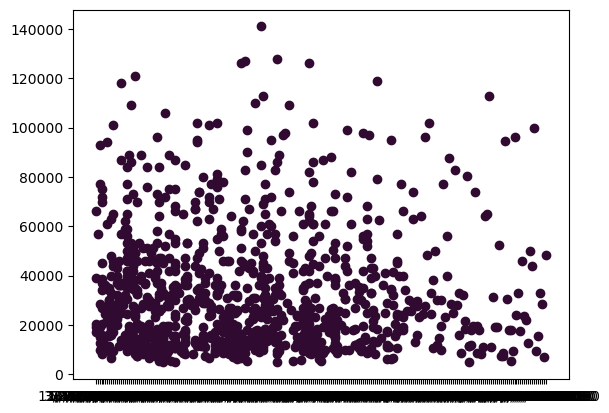

In [5]:
fig, ax = plt.subplots()
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000], color="#310a31");

In [6]:
df.saledate[:1000]

0      11/16/2006 0:00
1       3/26/2004 0:00
2       2/26/2004 0:00
3       5/19/2011 0:00
4       7/23/2009 0:00
            ...       
995     7/16/2009 0:00
996     6/14/2007 0:00
997     9/22/2005 0:00
998     7/28/2005 0:00
999     6/16/2011 0:00
Name: saledate, Length: 1000, dtype: object

<Axes: ylabel='Frequency'>

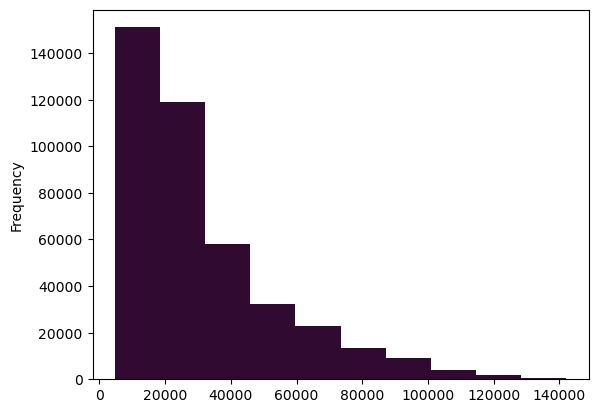

In [7]:
df.SalePrice.plot.hist(color="#310a31")

#### Parsing Dates

When we work with time series data, we want to enrich the time and date component as much as possible.

We can do that by telling pandas which of our columns has dates in it using the 'parse_dates' parameter.

In [8]:
df = pd.read_csv('data/TrainAndValid.csv',
                 low_memory=False,
                 parse_dates=['saledate'])

In [9]:
df.saledate.dtype

dtype('<M8[ns]')

In [10]:
df.saledate[:1000]

0     2006-11-16
1     2004-03-26
2     2004-02-26
3     2011-05-19
4     2009-07-23
         ...    
995   2009-07-16
996   2007-06-14
997   2005-09-22
998   2005-07-28
999   2011-06-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

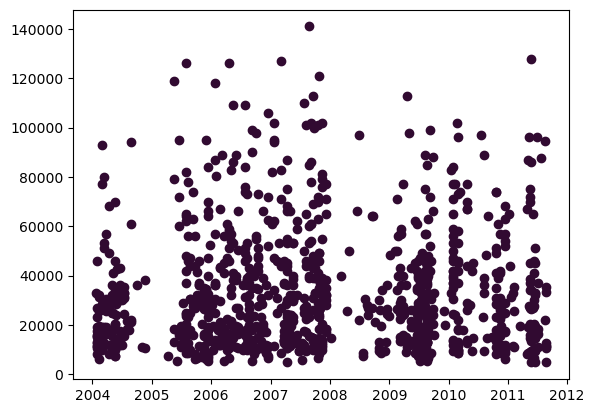

In [11]:
fig, ax = plt.subplots()
ax.scatter(df.saledate[:1000], df.SalePrice[:1000], color="#310a31");

In [12]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


#### Sorting Dates in the DataFrame
While working with time series data, it's a good idea to sort it by date.

In [14]:
# Sort DataFrame in date orde
df.sort_values(by = ['saledate'], inplace = True, ascending=True)

#### Making a copy of original DataFrame

In [15]:
df_temp = df.copy()

In [16]:
df_temp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


#### Add datetime parameters for `saledate` column

In [17]:
df_temp[:1].saledate.dt.year

205615    1989
Name: saledate, dtype: int32

In [18]:
df_temp[:1].saledate

205615   1989-01-17
Name: saledate, dtype: datetime64[ns]

In [19]:
df_temp['saleYear'] = df_temp.saledate.dt.year
df_temp['saleMonth'] = df_temp.saledate.dt.month
df_temp['saleDay'] = df_temp.saledate.dt.day
df_temp['saleDayOfWeek'] = df_temp.saledate.dt.dayofweek
df_temp['saleDayOfYear'] = df_temp.saledate.dt.dayofyear

In [20]:
df_temp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [21]:
df_temp.drop('saledate', axis=1, inplace=True)
df_temp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [22]:
df_temp.state.value_counts()

state
Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virgi

## 5. Modelling
We've done enough EDA (could do more ofc), but proceeding towards model-driven EDA.

In [23]:
# Building ML Model
from sklearn.ensemble import RandomForestRegressor

# Will give error - ValueError: could not convert string to float: 'Low'

# model = RandomForestRegressor(n_jobs=-1, # Use more cores on computer
#                               random_state=42) # same as np.random.seed(42)

# model.fit(df_temp.drop('SalePrice', axis=1), df_temp['SalePrice'])

In [24]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-null   o

In [25]:
df_temp['UsageBand'].dtype

dtype('O')

In [26]:
df_temp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

##### Converting String into Categories
One way is we can turn all our data into numbers is by converting them into pandas categories

In [27]:
df_temp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [28]:
pd.api.types.is_string_dtype(df_temp["UsageBand"])

False

In [29]:
# Check columns which *aren't* numeric
for label, content in df_temp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)
 
# This will turn all of the string values into category values
for label, content in df_temp.items():
    if pd.api.types.is_object_dtype(content):
        df_temp[label] = content.astype("category").cat.as_ordered()

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [30]:
# df.items()

temp_dict = {
    'key1' : 'hello',
    'key2' : 'world'
}

for key, value in temp_dict.items():
    print(f"This is a key: {key}")
    print(f"This is a value: {value}")
    print('\n')

This is a key: key1
This is a value: hello


This is a key: key2
This is a value: world




In [31]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor         748

In [32]:
df_temp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [33]:
df_temp.state.value_counts()

state
Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virgi

In [34]:
df_temp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

The 'category' datatype assigned a numerical code to all the string values, under the hood.

Thanks to pandas Categories, we have a way to access all of our data in the form of numbers. But we still have some missing data:

In [35]:
# Percentage of missing data under each label
df_temp.isna().sum()/len(df_temp) * 100

SalesID                      0.000000
SalePrice                    0.000000
MachineID                    0.000000
ModelID                      0.000000
datasource                   0.000000
auctioneerID                 4.879113
YearMade                     0.000000
MachineHoursCurrentMeter    64.258610
UsageBand                   82.149174
fiModelDesc                  0.000000
fiBaseModel                  0.000000
fiSecondaryDesc             34.099269
fiModelSeries               85.784520
fiModelDescriptor           81.871490
ProductSize                 52.485110
fiProductClassDesc           0.000000
state                        0.000000
ProductGroup                 0.000000
ProductGroupDesc             0.000000
Drive_System                74.051970
Enclosure                    0.080931
Forks                       52.092087
Pad_Type                    80.349796
Ride_Control                62.992794
Stick                       80.349796
Transmission                54.444412
Turbocharged

#### Saving Preprocessed Data

In [36]:
# Exporting current temp data
df_temp.to_csv("data/train_temp.csv", index = False)

In [37]:
# Importing preprocessed data
df_temp = pd.read_csv("data/train_temp.csv", low_memory = False)

In [38]:
df_temp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


#### Filling Missing Values

**Starting with numeric**

In [39]:
for labels, content in df_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(labels)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayOfWeek
saleDayOfYear


In [40]:
# Check which numeric columns have missing values

for labels, content in df_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(labels)

auctioneerID
MachineHoursCurrentMeter


In [41]:
# Filling numeric rows with median
for labels, content in df_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Adding a binary column to tell us if the data was missing or not
            df_temp[labels + "_is_missing"] = pd.isnull(content)
            df_temp[labels] = content.fillna(content.median())

We used median, and not mean because median is more robust than mean or mode.

In [42]:
# Are there any remaining null numeric values?
for label, content in df_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [43]:
# Checking how many examples were missing
df_temp.auctioneerID_is_missing.value_counts()

# True should be equal to 20136

auctioneerID_is_missing
False    392562
True      20136
Name: count, dtype: int64

In [44]:
df_temp.isna().sum()

SalesID                                     0
SalePrice                                   0
MachineID                                   0
ModelID                                     0
datasource                                  0
auctioneerID                                0
YearMade                                    0
MachineHoursCurrentMeter                    0
UsageBand                              339028
fiModelDesc                                 0
fiBaseModel                                 0
fiSecondaryDesc                        140727
fiModelSeries                          354031
fiModelDescriptor                      337882
ProductSize                            216605
fiProductClassDesc                          0
state                                       0
ProductGroup                                0
ProductGroupDesc                            0
Drive_System                           305611
Enclosure                                 334
Forks                             

#### Filling and turning categorical variables into numbers

In [45]:
#Check for columns which are not numeric

for label, content in df_temp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [46]:
pd.Categorical(df_temp['state']).codes

array([43,  8,  8, ...,  4,  4,  4], dtype=int8)

In [47]:
# Turn categorical data into numbers and fill missing data

for label, content in df_temp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to check if the label had missing values
        df_temp[label + "_is_missing"] = pd.isnull(content)
        #Turn categories into numbers and add 1
        df_temp[label] = pd.Categorical(content).codes + 1

We added the 1 because `pd.Categorical(content).codes` automatically assigns the missing values a value of -1. We don't want that.

In [48]:
df_temp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

Now that all of our data is numeric, and non e of our data has missing values, we can finally build and fit a machine learning model

In [49]:
df_temp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,False
Blade_Type_is_missing,False,True,False,True,False
Travel_Controls_is_missing,False,True,False,True,False
Differential_Type_is_missing,True,False,True,False,True


In [50]:
from sklearn.ensemble import RandomForestRegressor
%time 

# Instantiating Model
model = RandomForestRegressor(n_jobs = -1,
                              random_state = 42)

# Fitting Model
model.fit(df_temp.drop('SalePrice', axis=1), df_temp['SalePrice'])

CPU times: total: 0 ns
Wall time: 0 ns


RandomForestRegressor(n_jobs=-1, random_state=42)

In [51]:
model.score(df_temp.drop('SalePrice', axis=1), df_temp['SalePrice'])

0.9875468079970562

**Question: Ask yourself, Why isn't the above metric reliable?**

#### Splitting Data into train/validation sets

In [52]:
df_temp.saleYear.value_counts()

saleYear
2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: count, dtype: int64

In [53]:
# Split into training and validation datasets
df_val = df_temp[df_temp.saleYear == 2012]
df_train = df_temp[df_temp.saleYear != 2012]

len(df_val), len(df_train)

(11573, 401125)

In [54]:
# Split the data into X and y
X_train, y_train = df_train.drop('SalePrice', axis = 1), df_train.SalePrice

X_valid, y_valid = df_val.drop('SalePrice', axis = 1), df_val.SalePrice

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

#### Building our own evaluation function

In [55]:
# Create evaluation function: RMSLE
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
    """
    Calculates root mean squared log error between predictions and true labels
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))
    
# Create function to evaluate model on a few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {
        "Training MAE " : mean_absolute_error(y_train, train_preds),
        "Valid MAE " : mean_absolute_error(y_valid, val_preds),
        "Training RMSLE " : rmsle(y_train, train_preds),
        "Valid RMSLE " : rmsle(y_valid, val_preds),
        "Training R^2 " : r2_score(y_train, train_preds),
        "Valid R^2 " : r2_score(y_valid, val_preds)
    }
    return scores

#### Testing our model on a subset (to tune the hyperparameters)

In [56]:
# Changing max_samples value
model = RandomForestRegressor(n_jobs = -1,
                              random_state = 42,
                              max_samples = 10000)

model.fit(X_train, y_train)

RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [57]:
show_scores(model)

{'Training MAE ': 5561.2988092240585,
 'Valid MAE ': 7177.26365505919,
 'Training RMSLE ': 0.257745378256977,
 'Valid RMSLE ': 0.29362638671089003,
 'Training R^2 ': 0.8606658995199189,
 'Valid R^2 ': 0.8320374995090507}

#### Hyperparameter tuning with RandomizedSearchCV

In [58]:
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters

rf_grid = {
    "n_estimators" : np.arange(10,100,10),
    "max_depth" : [None, 3, 5, 10],
    "min_samples_split" : np.arange(2,20,2),
    "min_samples_leaf" : np.arange(1,20,2),
    "max_features" : [0.5, 1, "sqrt", 1.0],
    "max_samples" : [10000]
}

# Instantiating RandomizedSearchCV
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs = -1, 
                                                    random_state = 42),
                              param_distributions = rf_grid,
                              n_iter = 5,
                              cv = 5,
                              verbose = True,
                              error_score='raise')

# Fit the RandomizedSearchCV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=5,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt', 1.0],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [59]:
rs_model.best_params_

{'n_estimators': 10,
 'min_samples_split': 2,
 'min_samples_leaf': 7,
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': 10}

In [60]:
show_scores(rs_model)

{'Training MAE ': 7137.467846490499,
 'Valid MAE ': 8456.011177488184,
 'Training RMSLE ': 0.31666873130700995,
 'Valid RMSLE ': 0.3423022434079117,
 'Training R^2 ': 0.7827911986187425,
 'Valid R^2 ': 0.7760427371431887}

#### Train a model with the best hyperparameters
**Note:** These were found after 1000 iterations of 'RandomizedSearchCV'

In [61]:
# Most ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators = 40,
                                    min_samples_leaf = 1,
                                    min_samples_split = 14,
                                    max_features = 0.5,
                                    n_jobs = -1,
                                    max_samples = None,
                                    random_state = 42)

# Fit the ideal model
ideal_model.fit(X_train, y_train)

RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1, random_state=42)

In [62]:
show_scores(ideal_model)

{'Training MAE ': 2953.8161137163484,
 'Valid MAE ': 5951.247761444453,
 'Training RMSLE ': 0.14469006962371858,
 'Valid RMSLE ': 0.24524163989538328,
 'Training R^2 ': 0.9588145522577225,
 'Valid R^2 ': 0.8818019502450094}

#### Make predictions on test data

In [63]:
# Import the test data

df_test = pd.read_csv("data/Test.csv",
                     low_memory = False,
                     parse_dates = ["saledate"])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [64]:
df_test.isna().sum()

SalesID                         0
MachineID                       0
ModelID                         0
datasource                      0
auctioneerID                    0
YearMade                        0
MachineHoursCurrentMeter    10328
UsageBand                   10623
saledate                        0
fiModelDesc                     0
fiBaseModel                     0
fiSecondaryDesc              3975
fiModelSeries               10451
fiModelDescriptor            9433
ProductSize                  6409
fiProductClassDesc              0
state                           0
ProductGroup                    0
ProductGroupDesc                0
Drive_System                 9698
Enclosure                       2
Forks                        6149
Pad_Type                    10349
Ride_Control                 8216
Stick                       10349
Transmission                 7639
Turbocharged                10349
Blade_Extension             11806
Blade_Width                 11806
Enclosure_Type

#### Preprocessing the data
Getting the test dataset in the same format as the training dataset

In [65]:
def preprocess_data(df):
    """
    Performs transformations on df and returns transformed df
    """
    df['saleYear'] = df.saledate.dt.year
    df['saleMonth'] = df.saledate.dt.month
    df['saleDay'] = df.saledate.dt.day
    df['saleDayOfWeek'] = df.saledate.dt.dayofweek
    df['saleDayOfYear'] = df.saledate.dt.dayofyear

    df.drop('saledate', axis = 1, inplace = True)

    # Fill the missing numeric data with median
    for labels, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add a binary column to tell us if the data was missing or not
                df[labels + "_is_missing"] = pd.isnull(content)
                # Fill missing null values with the median
                df[labels] = content.fillna(content.median())
                
    # Fill categorical missing data and turned categories into numbers
        if not pd.api.types.is_numeric_dtype(content):
                # Add binary column to check if the label had missing values:
                df[labels + "_is_missing"] = pd.isnull(content)
                # Turn categories into numbers and add 1
                df[labels] = pd.Categorical(content).codes + 1
        
    return df

In [66]:
# Process the test data
df_test = preprocess_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [67]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,True,True,True,True,True,False,False,False,True,True
1,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,...,True,True,True,True,True,True,True,True,False,False
2,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,...,True,True,True,True,True,False,False,False,True,True
3,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,...,True,True,True,True,True,True,True,True,False,False
4,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,...,True,True,True,True,True,False,False,False,True,True


In [68]:
# X_train has 102 columns and test.csv had 101 column 

# Finding how column differs using sets.
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

In [69]:
# Manually adjust df_test to have the above missing columns
df_test['auctioneerID_is_missing'] = False
df_test = df_test.reindex(columns=list(X_train.columns))
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


Now we have same number of columns on both the datasets i.e - 102. <br>
Therefore, we can now proceed towards making prediction

In [70]:
test_preds = ideal_model.predict(df_test)
test_preds

array([17030.00927386, 14355.53565165, 46623.08774286, ...,
       11964.85073347, 16496.71079281, 27119.99044029])

In [71]:
len(test_preds)

12457

In [78]:
# Format predictions into the same format as asked

df_preds = pd.DataFrame()
df_preds['SalesID'] = df_test['SalesID']
df_preds['SalesPrice'] = test_preds
df_preds

,SalesID,SalesPrice
0,1227829,17030.009274
1,1227844,14355.535652
2,1227847,46623.087743
3,1227848,71680.261335
4,1227863,61762.999424
...,...,...
12452,6643171,39966.363007
12453,6643173,12049.704433
12454,6643184,11964.850733
12455,6643186,16496.710793


In [73]:
# Exporting Prediction Data
df_preds.to_csv('data/test_predictions.csv', index=False)

#### Feature Importance
Which different attributes were most important when it comes to predicting the prices

In [74]:
len(ideal_model.feature_importances_)

102

In [75]:
X_train.shape

(401125, 102)

In [76]:
# Plotting feature importance
def plot_features(columns, importances, n = 20):
    df = (pd.DataFrame({'features' : columns,
                        'feature_importances' : importances})
          .sort_values('feature_importances', ascending = False).reset_index(drop = True))

    #Plot the df
    fig, ax = plt.subplots()
    ax.barh(df['features'][:n], df['feature_importances'][:20], color="#847996")
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

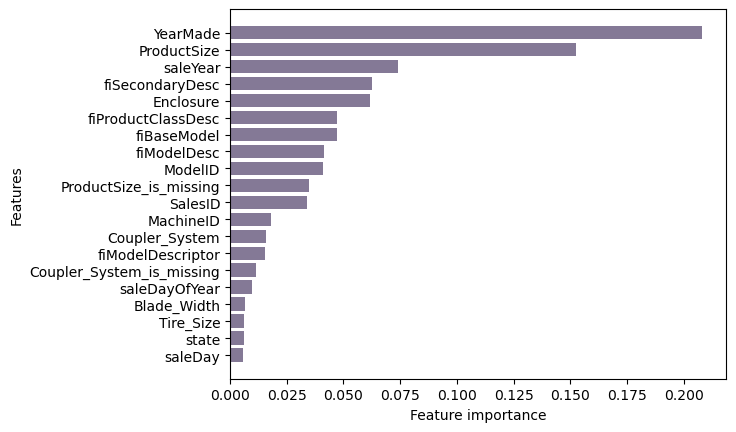

In [77]:
plot_features(X_train.columns, ideal_model.feature_importances_);